In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import math
import json
import ccxt

In [2]:
def convert_tz(utc):
    from_zone = tz.tzutc()
    to_zone = tz.tzlocal()
    utc = utc.replace(tzinfo=from_zone).astimezone(to_zone)
    
    return utc

In [3]:
def get_date_list(start_date, end_date=None):
    '''
    Generate list of date to fetch 1 day iteration from fetch_ohlcv.
    '''
    if end_date == None:
        end_date = dt.date.today()
    
    num_day = (end_date - start_date).days
    date_list = [dt.date.today() - dt.timedelta(days = x) for x in range(num_day, 0, -1)]
    
    return date_list

In [4]:
def get_js_date(dt_date):
    '''
    Transform dt.datetime to JavaScript format.
    '''
    dt_datetime = dt.datetime(dt_date.year, dt_date.month, dt_date.day)
    js_datetime = dt_datetime.timestamp() * 1000
    
    return js_datetime

In [5]:
def get_ohlcv(symbol, date_list, timeframe, limit, exchange):
    df = pd.DataFrame(columns = ['time', 'open', 'high', 'low', 'close', 'volume'])

    for i in range(len(date_list)):
        since = get_js_date(date_list[i])
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        temp_df = pd.DataFrame(ohlcv)
        temp_df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
        temp_df['time'] = pd.to_datetime(temp_df['time'], unit='ms')
        temp_df['time'] = temp_df['time'].apply(lambda x: convert_tz(x))

        df = pd.concat([df, temp_df])

    df = df.reset_index(drop=True)

    return df

In [6]:
def get_timeframe(interval):
    timeframe_dict = {1440:'1d', 240:'4h', 60:'1h', 30:'30m', 15:'15m'}
    
    for i in timeframe_dict.keys():
        if interval % i == 0:
            min_interval = i
            break
            
    min_timeframe = timeframe_dict[min_interval]
    step = int(interval / min_interval)
            
    return min_timeframe, step

In [7]:
def group_timeframe(df, step):
    h_dict = {'time':[], 'open':[], 'high':[], 'low':[], 'close':[]}
    
    mod = len(df) % step
    if  mod != 0:
        df = df.iloc[:-mod, :]
        
    for i in [x for x in range(0, len(df), step)]:
        temp_df = df.iloc[i:i + step, :]
        h_dict['time'].append(temp_df['time'][i])
        h_dict['open'].append(temp_df['open'][i])
        h_dict['high'].append(max(temp_df['high']))
        h_dict['low'].append(min(temp_df['low']))
        h_dict['close'].append(temp_df['close'][i + 1])

    df = pd.DataFrame(h_dict)
    
    return df

In [8]:
def get_signal(df, signal, window):
    func_dict = {'tma': signal_tma}
    
    df = func_dict[signal](df, window)
    
    return df

In [9]:
def signal_tma(df, window):
    sub_interval = (window + 1) / 2
    
    # trunc ma to get minimum avg steps
    df['ma'] = df['close'].rolling(window=math.trunc(sub_interval)).mean()
    
    # round tma to reach window steps
    df['signal'] = df['ma'].rolling(window=int(np.round(sub_interval))).mean()
    
    df = df.drop(columns=['ma'])
    df = df.dropna().reset_index(drop=True)
    
    return df

In [10]:
def round_down_amount(amount, decimal):
    floor_amount = np.floor((amount * (10 ** decimal))) / (10 ** decimal)
    
    return floor_amount

### Config 

In [11]:
with open('../../../_keys/ftx/ftx_test_keys.json') as keys_file:
    keys_dict = json.load(keys_file)

In [12]:
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

In [13]:
base_currency = 'ETH'
quote_currency = 'USD'
decimal = 3

In [14]:
file_path = 'data'

In [15]:
signal = 'tma'
interval = 15
window = 50

In [16]:
start_date = dt.date(2021, 1, 1) # first available data
end_date = dt.date(2021, 7, 26)

### Get timeframe 

In [17]:
min_timeframe, step = get_timeframe(interval)

In [18]:
limit = int(1440 / (interval / step))

### Get data

In [19]:
symbol = '{}/{}'.format(base_currency, quote_currency)

In [20]:
date_list = get_date_list(start_date, end_date)

In [21]:
raw_df = get_ohlcv(symbol, date_list, min_timeframe, limit, exchange)

In [22]:
raw_df

,time,open,high,low,close,volume
0,2021-01-11 00:00:00+07:00,1299.2,1304.6,1283.1,1295.0,1.693833e+06
1,2021-01-11 00:15:00+07:00,1295.0,1295.0,1261.9,1271.2,1.297876e+06
2,2021-01-11 00:30:00+07:00,1271.2,1280.6,1247.0,1269.3,2.046958e+06
3,2021-01-11 00:45:00+07:00,1269.3,1305.6,1264.3,1302.0,7.224795e+05
4,2021-01-11 01:00:00+07:00,1302.0,1313.4,1297.3,1305.5,1.405367e+06
...,...,...,...,...,...,...
19771,2021-08-04 22:45:00+07:00,2665.9,2676.6,2663.6,2673.3,3.027698e+06
19772,2021-08-04 23:00:00+07:00,2673.3,2727.5,2666.1,2713.6,1.742171e+07
19773,2021-08-04 23:15:00+07:00,2713.5,2724.1,2694.4,2701.2,7.824130e+06
19774,2021-08-04 23:30:00+07:00,2701.2,2721.0,2696.0,2718.9,4.533317e+06


### Group timeframe

In [23]:
if step > 1:
    df = group_timeframe(raw_df, step)
else:
    df = raw_df.copy()

In [24]:
df

,time,open,high,low,close,volume
0,2021-01-11 00:00:00+07:00,1299.2,1304.6,1283.1,1295.0,1.693833e+06
1,2021-01-11 00:15:00+07:00,1295.0,1295.0,1261.9,1271.2,1.297876e+06
2,2021-01-11 00:30:00+07:00,1271.2,1280.6,1247.0,1269.3,2.046958e+06
3,2021-01-11 00:45:00+07:00,1269.3,1305.6,1264.3,1302.0,7.224795e+05
4,2021-01-11 01:00:00+07:00,1302.0,1313.4,1297.3,1305.5,1.405367e+06
...,...,...,...,...,...,...
19771,2021-08-04 22:45:00+07:00,2665.9,2676.6,2663.6,2673.3,3.027698e+06
19772,2021-08-04 23:00:00+07:00,2673.3,2727.5,2666.1,2713.6,1.742171e+07
19773,2021-08-04 23:15:00+07:00,2713.5,2724.1,2694.4,2701.2,7.824130e+06
19774,2021-08-04 23:30:00+07:00,2701.2,2721.0,2696.0,2718.9,4.533317e+06


### Get signal

In [25]:
df = get_signal(df, signal, window)

In [26]:
df

,time,open,high,low,close,volume,signal
0,2021-01-11 12:15:00+07:00,1120.1,1128.4,1097.4,1120.0,1.000616e+06,1236.329846
1,2021-01-11 12:30:00+07:00,1120.0,1123.9,1098.4,1101.2,1.329672e+06,1232.345538
2,2021-01-11 12:45:00+07:00,1101.2,1104.4,1079.5,1092.9,2.080525e+06,1228.129692
3,2021-01-11 13:00:00+07:00,1092.9,1093.8,1057.7,1059.8,4.152529e+06,1223.616769
4,2021-01-11 13:15:00+07:00,1059.8,1087.7,1054.4,1082.9,1.723165e+06,1218.904923
...,...,...,...,...,...,...,...
19722,2021-08-04 22:45:00+07:00,2665.9,2676.6,2663.6,2673.3,3.027698e+06,2508.137231
19723,2021-08-04 23:00:00+07:00,2673.3,2727.5,2666.1,2713.6,1.742171e+07,2511.668154
19724,2021-08-04 23:15:00+07:00,2713.5,2724.1,2694.4,2701.2,7.824130e+06,2515.562154
19725,2021-08-04 23:30:00+07:00,2701.2,2721.0,2696.0,2718.9,4.533317e+06,2519.824923


### Run simulation 

In [27]:
simu_df = df.copy()

In [28]:
budget = 100
last_action_price = 0
last_action_amount = 0

In [29]:
signal_dict = {'action':[], 'action_price':[], 'budget':[], 'profit':[], 'drawdown':[]}

for i in range(len(simu_df)):
    if df['close'][i] > df['signal'][i]:
        action = 'buy'
    elif df['close'][i] < df['signal'][i]:
        action = 'sell'
    else:
        action = signal_dict['action'][-1]
    
    if i > 0:
        if action != signal_dict['action'][-1]:
            if last_action_price > 0:
                if action == 'buy':
                    profit = (last_action_price - df['close'][i]) * last_action_amount
                elif action == 'sell':
                    profit = (df['close'][i] - last_action_price) * last_action_amount

            last_action_price = df['close'][i]
            last_action_amount = round_down_amount(budget / last_action_price, decimal)
            
            budget += profit
        else:
            profit = 0
    else:
        profit = 0
        
    
    if last_action_price > 0:
        if action == 'buy':
            drawdown = (df['low'][i] - last_action_price) / last_action_price
        elif action == 'sell':
            drawdown = (last_action_price - df['high'][i]) / last_action_price
    else:
        drawdown = 0
        max_drawdown = 0
        
    signal_dict['action'].append(action)
    signal_dict['action_price'].append(last_action_price)
    signal_dict['budget'].append(budget)
    signal_dict['profit'].append(profit)
    signal_dict['drawdown'].append(drawdown)

In [30]:
budget

148.3429999999998

In [31]:
for s in signal_dict.keys():
    simu_df[s] = signal_dict[s]

In [32]:
simu_df.to_csv('simulation.csv', index=False)

### Viz 

In [33]:
import matplotlib.pyplot as plt

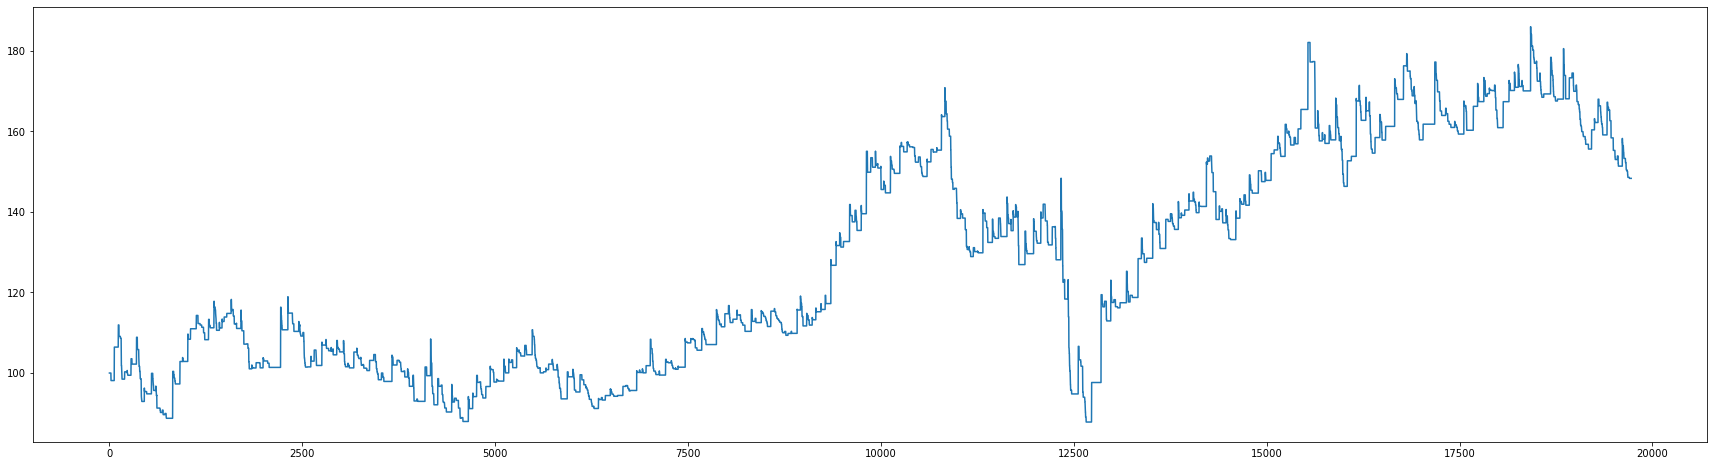

In [34]:
fig, ax = plt.subplots(figsize=(30, 8))
ax.plot(simu_df['budget'])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   1.,   0., 

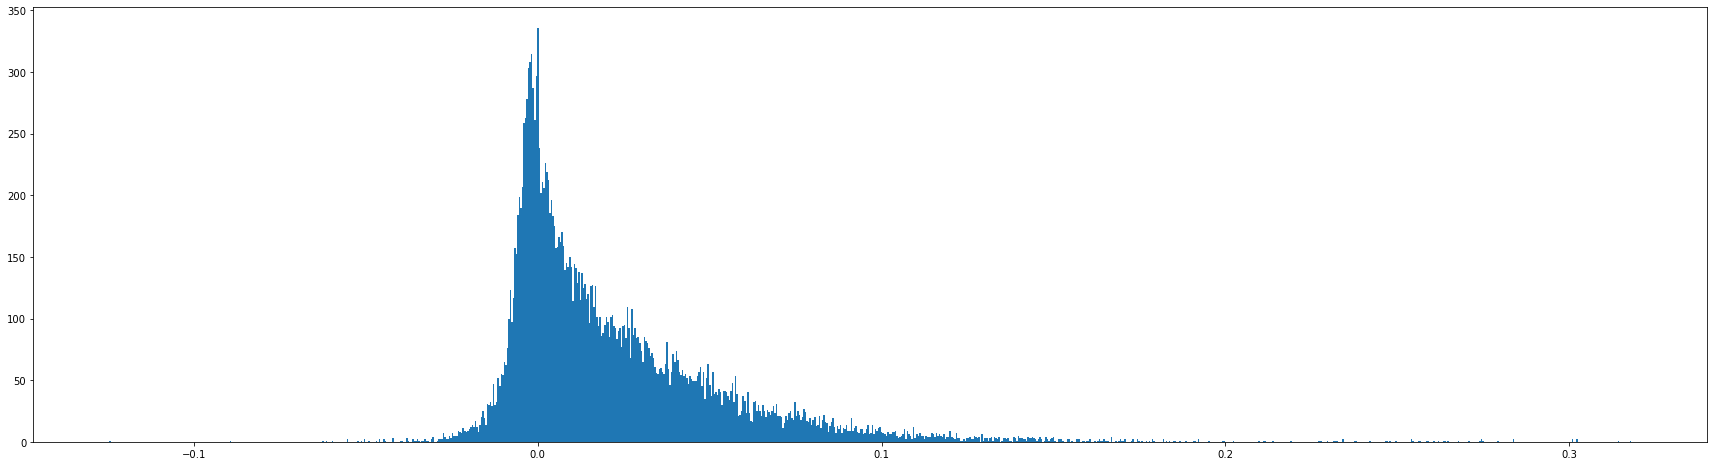

In [35]:
fig, ax = plt.subplots(figsize=(30,8))
ax.hist(simu_df['drawdown'], bins=1000)

In [36]:
simu_df['drawdown'].describe()

count    19727.000000
mean         0.021731
std          0.032513
min         -0.124563
25%         -0.000395
50%          0.011694
75%          0.034789
max          0.318034
Name: drawdown, dtype: float64